In [111]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [112]:
df = pd.read_csv('data/ai4i2020.csv')
df.rename(columns={'UDI':'UID'}, inplace=True)

In [113]:
df.head()

,UID,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [114]:
# Failures by type
# ---------------

failures = df['Machine failure'].value_counts()
failures

Machine failure
0    9661
1     339
Name: count, dtype: int64

In [115]:
# Type label encoding
# ---------------

type_label = {'L': 0, 'M': 1, 'H': 2}
df['Type'] = df['Type'].map(type_label)

In [116]:
# Normalize the data
# ------------------

columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
scaler = MinMaxScaler()
df[columns] = scaler.fit_transform(df[columns])

In [117]:
df

,UID,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,1,0.304348,0.358025,0.222934,0.535714,0.000000,0,0,0,0,0,0
1,2,L47181,0,0.315217,0.370370,0.139697,0.583791,0.011858,0,0,0,0,0,0
2,3,L47182,0,0.304348,0.345679,0.192084,0.626374,0.019763,0,0,0,0,0,0
3,4,L47183,0,0.315217,0.358025,0.154249,0.490385,0.027668,0,0,0,0,0,0
4,5,L47184,0,0.315217,0.370370,0.139697,0.497253,0.035573,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,1,0.380435,0.333333,0.253783,0.353022,0.055336,0,0,0,0,0,0
9996,9997,H39410,2,0.391304,0.333333,0.270081,0.384615,0.067194,0,0,0,0,0,0
9997,9998,M24857,1,0.402174,0.358025,0.277648,0.406593,0.086957,0,0,0,0,0,0
9998,9999,H39412,2,0.402174,0.370370,0.139697,0.614011,0.098814,0,0,0,0,0,0


In [118]:
# Define X and y
# ---------------

X = df.drop(['UID', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = df['Machine failure']

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

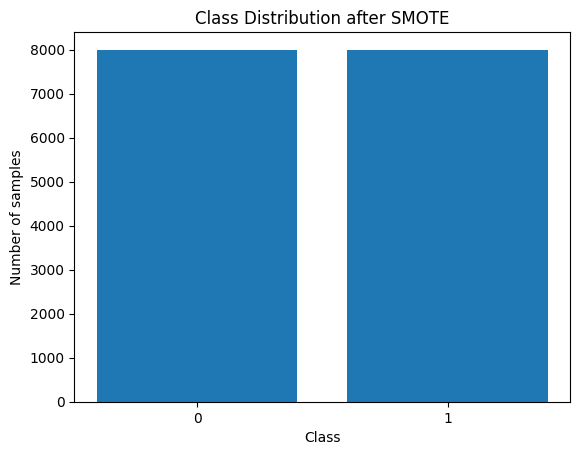

In [119]:
# Do SMOTE for the unbalanced data
# ---------------

strategy = {0: 8000, 1: 8000}
smote = SMOTE(sampling_strategy=strategy)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

counter_smote = Counter(y_train_smote)

# Plot
plt.bar(counter_smote.keys(), counter_smote.values())
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution after SMOTE')
plt.xticks(list(counter_smote.keys()))
plt.show()

In [123]:
# Model
# ---------------

class_weights = {0: 1.0, 1: 2.0}
model = RandomForestClassifier(n_estimators=1000,
                               bootstrap=False, 
                               class_weight=class_weights, 
                               random_state=42)

model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(bootstrap=False, class_weight={0: 1.0, 1: 2.0},
                       n_estimators=1000, random_state=42)

In [124]:
# Evaluate model on original test data
# ---------------

y_pred = model.predict(X_val)

print("Evaluation results:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Evaluation results:
Accuracy: 0.9695
Confusion Matrix:
 [[1894   45]
 [  16   45]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1939
           1       0.50      0.74      0.60        61

    accuracy                           0.97      2000
   macro avg       0.75      0.86      0.79      2000
weighted avg       0.98      0.97      0.97      2000

